# Evaluate water mass properties on the Amundsen Shelf using Pierre's observations

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as cl
import cmocean
import sys
sys.path.append('/home/users/birgal/')
from nemo_python_git.plots import circumpolar_plot, finished_plot
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from nemo_python_git.file_io import read_dutrieux
from nemo_python_git.utils import convert_to_teos10
from nemo_python_git.interpolation import interp_latlon_cf
import glob

In [2]:
base_dir = '/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/'
run_folder    = f'{base_dir}output/ERA5_test4_cont/'
nemo_mesh     = f'{base_dir}bathymetry/mesh_mask-20240305.nc'
nemo_domain   = f'{base_dir}bathymetry/domain_cfg-20240305.nc'

In [3]:
def plot_land(nemo_mesh, file_var):
    lon_plot = np.ma.masked_where(nemo_mesh.tmask.isel(nav_lev=0) != 0, nemo_mesh.nav_lon.values)
    lat_plot = np.ma.masked_where(nemo_mesh.tmask.isel(nav_lev=0) != 0, nemo_mesh.nav_lat.values)
    plot_var = np.ma.masked_where(nemo_mesh.tmask.isel(nav_lev=0) != 0, file_var.values)
    return lon_plot, lat_plot, plot_var 

## Look at near-bottom T and S 

In [4]:
obs = read_dutrieux(eos='teos10')

# extract the bottom temperatures and salinities !!! Note that these are the deepest T, S in the dataset, not necessarily the bottom T, S
depth_bottom_obs = xr.where(obs['ConsTemp'].notnull(),-1*obs.coords['depth'],np.nan).max(dim='depth')
depth_bottom_obs = xr.where(depth_bottom_obs < 200, np.nan, depth_bottom_obs) # mask areas shallower than 200 m
bottom_Tobs      = xr.where(-1*obs.coords['depth']==depth_bottom_obs, obs['ConsTemp'], np.nan).mean(dim='depth')
bottom_Sobs      = xr.where(-1*obs.coords['depth']==depth_bottom_obs, obs['AbsSal'], np.nan).mean(dim='depth')

obs_bottom = xr.Dataset({'temp':bottom_Tobs, 'salt':bottom_Sobs, 'depth':depth_bottom_obs})

In [5]:
# load nemo grid for interpolation
nemo_ds_ref  = xr.open_dataset(f'{run_folder}eANT025.L121_1m_19790101_19791231_grid_T.nc') # load all the gridT files in the run folder
nemo_ds_ref  = nemo_ds_ref.rename({'e3t':'thkcello', 'x_grid_T':'x', 'y_grid_T':'y', 'area_grid_T':'area', 'e3t':'thkcello',
                          'nav_lon_grid_T':'nav_lon', 'nav_lat_grid_T':'nav_lat', 
                          'bounds_nav_lon_grid_T':'bounds_lon', 'bounds_nav_lat_grid_T':'bounds_lat',
                          'nvertex_grid_T':'nvertex'})

In [6]:
obs_interp = interp_latlon_cf(obs_bottom, nemo_ds_ref.isel(x=slice(450, 900), y=slice(130,350)), method='bilinear')

In [ ]:
# load nemo simulations
gridT_files = glob.glob(f'{run_folder}/*grid_T*')
nemo_ds     = xr.open_mfdataset(gridT_files) # load all the gridT files in the run folder

nemo_ds = nemo_ds.rename({'e3t':'thkcello', 'x_grid_T':'x', 'y_grid_T':'y', 'area_grid_T':'area', 'e3t':'thkcello',
                          'nav_lon_grid_T':'nav_lon', 'nav_lat_grid_T':'nav_lat', 
                          'bounds_nav_lon_grid_T':'bounds_lon', 'bounds_nav_lat_grid_T':'bounds_lat',
                          'nvertex_grid_T':'nvertex'})
    
# Average full time series:
nemo = nemo_ds.isel(time_counter=slice(180,None)).mean(dim='time_counter') # average (252, None) 2000-2016
# average (180, None) 1994-2016 (obs go to 2019)

In [ ]:
nemo_mesh_ds = xr.open_dataset(nemo_mesh)
mesh_sub  = nemo_mesh_ds.isel(x=slice(450, 900), y=slice(130,350), time_counter=0)

In [ ]:
bathy = xr.where((mesh_sub.isfdraft > 0) | (mesh_sub.bathy_metry==0), np.nan, mesh_sub.bathy_metry)

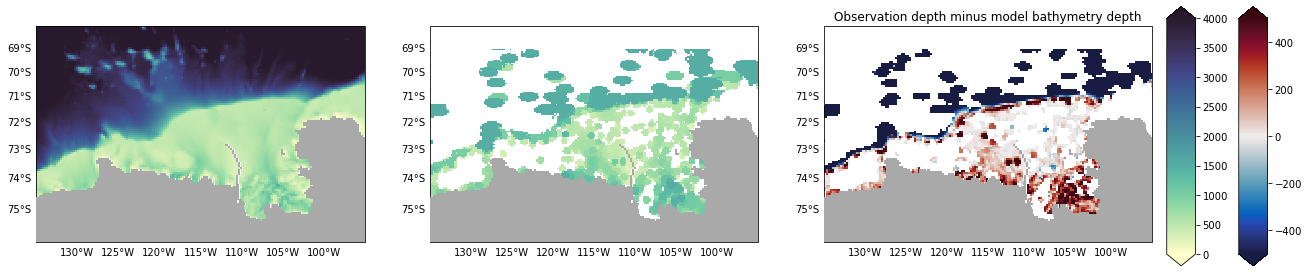

In [14]:
# These indices are based on eANT025; eventually should generalize based on lat, lon
nemo_mesh_ds = xr.open_dataset(nemo_mesh)
mesh_sub     = nemo_mesh_ds.isel(x=slice(450, 900), y=slice(130,350), time_counter=0)

fig, ax = plt.subplots(1,3, figsize=(20,12), subplot_kw={'projection': ccrs.Mercator(latitude_true_scale=-70)})

img1 = ax[0].pcolormesh(mesh_sub.nav_lon.values, mesh_sub.nav_lat.values, 
                        bathy.values, transform=ccrs.PlateCarree(),rasterized=True,cmap=cmocean.cm.deep,vmin=0,vmax=4000)

img2 = ax[1].pcolormesh(depth_bottom_obs.lon.values, depth_bottom_obs.lat.values, 
                        depth_bottom_obs.values, transform=ccrs.PlateCarree(),rasterized=True,cmap=cmocean.cm.deep,vmin=0,vmax=4000)

img3 = ax[2].pcolormesh(mesh_sub.nav_lon.values, mesh_sub.nav_lat.values, 
                        (obs_interp.depth.values - bathy.values), 
                        transform=ccrs.PlateCarree(),rasterized=True,cmap=cmocean.cm.balance,vmin=-500,vmax=500)
ax[2].set_title('Observation depth minus model bathymetry depth')

lon_land, lat_land, land_plt = plot_land(mesh_sub, mesh_sub.bathy_metry)
for axis in ax.ravel():
    axis.set_extent([-95, -135, -76, -68], ccrs.PlateCarree())
    gl = axis.gridlines(draw_labels=True);
    gl.xlines=None; gl.ylines=None; gl.top_labels=None; gl.right_labels=None;
    axis.pcolormesh(lon_land, lat_land, land_plt, transform=ccrs.PlateCarree(), rasterized=True, 
                    cmap=cl.ListedColormap(['DarkGrey']), zorder=3)

cax2 = fig.add_axes([0.91, 0.35, 0.02, 0.3])
cax3 = fig.add_axes([0.96, 0.35, 0.02, 0.3])
plt.colorbar(img2, cax=cax2, extend='both')
plt.colorbar(img3, cax=cax3, extend='both')

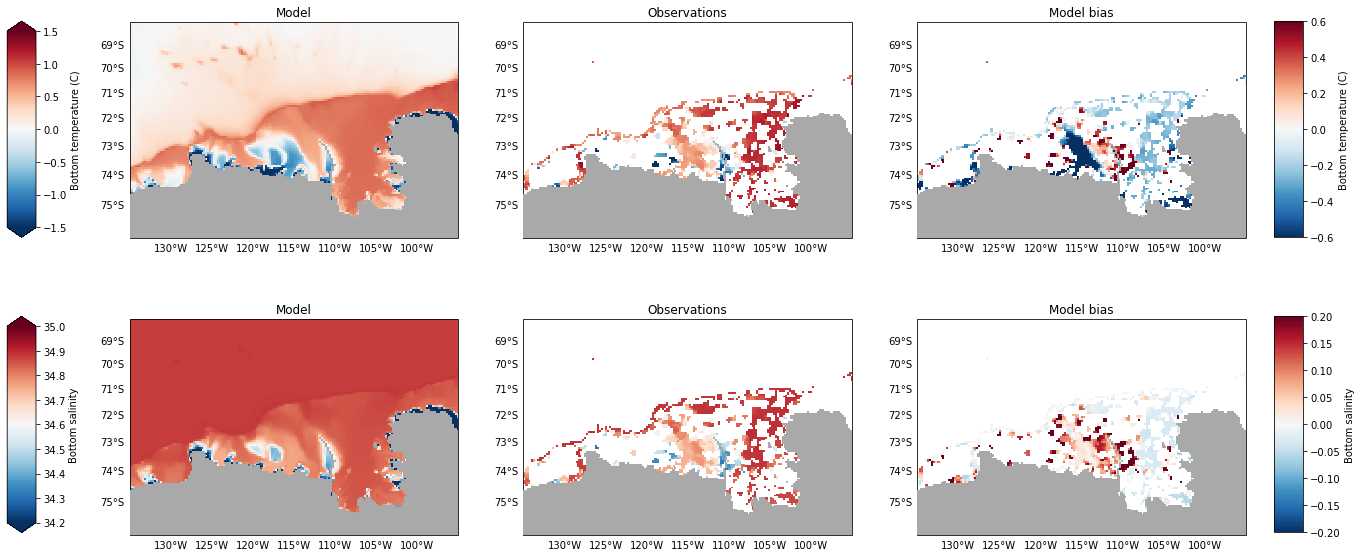

In [15]:
# Check that the observations depth is close enough to the bottom bathymetry to be considered representative

# Select the NEMO variables we need and time-average
nemo_plot = xr.Dataset({'temp':nemo['sbt'], 'salt':nemo['sbs']})
nemo_plot = nemo_plot.rename({'x_grid_T_inner':'x', 'y_grid_T_inner':'y'}).isel(x=slice(450, 900), y=slice(130,350))
# Apply NEMO land mask to both
nemo_plot = nemo_plot.where(nemo_plot['temp']!=0)
obs_plot  = obs_interp.where(nemo_plot['temp'].notnull()*obs_interp.notnull())
obs_plot  = obs_plot.where(nemo_plot['temp']!=0)
nemo_plot = nemo_plot.where(nemo_plot['temp']!=0)
# Get difference from obs
obs_plot = xr.where(np.abs((obs_interp.depth.values - bathy.values)) > 200, np.nan, obs_plot)
bias_plot = nemo_plot - obs_plot
    
# These indices are based on eANT025cax=cax, ; eventually should generalize based on lat, lon
lon_land, lat_land, land_plt = plot_land(mesh_sub, mesh_sub.bathy_metry)
# Little helper function to help cartopy with landmasking
def mask_land(nemo_mesh, file_var):
    lon_plot = np.ma.masked_where(mesh_sub.tmask.isel(nav_lev=0) == 0, mesh_sub.nav_lon.values)
    lat_plot = np.ma.masked_where(mesh_sub.tmask.isel(nav_lev=0) == 0, mesh_sub.nav_lat.values)
    plot_var = np.ma.masked_where(mesh_sub.tmask.isel(nav_lev=0) == 0, file_var.values)
    return lon_plot, lat_plot, plot_var 
      
data_plot  = [nemo_plot, obs_plot, bias_plot]
var_titles = ['Bottom temperature (C)', 'Bottom salinity']
vmin = [-1.5, -1.5, -0.6, 34.2, 34.2, -0.2]
vmax = [1.5, 1.5, 0.6, 35, 35, 0.2]

#------------- Plot figure -----------------
fig, ax = plt.subplots(2,3, figsize=(20,10), subplot_kw={'projection': ccrs.Mercator(latitude_true_scale=-70)})

for axis in ax.ravel():
    axis.set_extent([-95, -135, -76, -68], ccrs.PlateCarree())
    gl = axis.gridlines(draw_labels=True);
    gl.xlines=None; gl.ylines=None; gl.top_labels=None; gl.right_labels=None;

i=0nemo_TS_sub.so.values, nemo_TS_sub.thetao.values
for v, var in enumerate(['temp', 'salt']):
    for n, name in enumerate(['Model', 'Observations', 'Model bias']):
        lon_plt, lat_plt, var_plt = mask_land(mesh_sub, data_plot[n][var])
        img = ax[v,n].pcolormesh(lon_plt, lat_plt, var_plt, transform=ccrs.PlateCarree(), rasterized=True, cmap='RdBu_r', vmin=vmin[i], vmax=vmax[i])
        ax[v,n].pcolormesh(lon_land, lat_land, land_plt, transform=ccrs.PlateCarree(), rasterized=True, 
                           cmap=cl.ListedColormap(['DarkGrey']), zorder=3)
        ax[v,n].set_title(name)
        i+=1
        if n != 1:
            cax = fig.add_axes([0.04+0.44*n, 0.56-0.41*v, 0.02, 0.3])
            plt.colorbar(img, cax=cax, extend='both' if n==0 else 'neither', label=var_titles[v])

!!! Need some more observations in the Getz region to evaluate the bias there

### Visualize T-S diagram for full domain for one month 
Then, figure out how to visualize changes over time

In [ ]:
# select points in the amundsen sea region:



In [ ]:
# Helper function to split temperature and salinity in the given region (set by mask) into bins, 
# to get the volume in m^3 of each bin. The arrays can be time-dependent if you want. You can set 
# the bounds of the bins, but they must be at least as permissive as the bounds of the data in that region.
def ts_binning (temp, salt, grid, mask, num_bins=1000, 
                tmin=None, tmax=None, smin=None, smax=None):

    if len(mask.shape)==2 and not bdry: # Get 3D version of 2D mask
        mask = mask_2d_to_3d(mask, grid)
    dV = grid.dV

    # Inner function to get min and max values in region
    def get_vmin_vmax (data):
        vmin = np.amax(data)
        vmax = np.amin(data)
        data_tmp = data
        vmin = min(vmin, np.amin(data_tmp[mask]))
        vmax = max(vmax, np.amax(data_tmp[mask]))
        return [vmin, vmax]
        
    print('Calculating bounds')
    temp_bounds = get_vmin_vmax(temp)
    salt_bounds = get_vmin_vmax(salt)
    
    def check_bounds(min, max, bounds):
        if min is not None:
            if min > bounds[0]:
                print('Error (ts_binning): min is too high')
                sys.exit()
        bounds[0] = min
        if max < bounds[-1]:
            print('Error (ts_binning): max is too low')
            sys.exit()
        bounds[1] = max
        return bounds
        
    temp_bounds = check_bounds(tmin, tmax, temp_bounds)
    salt_bounds = check_bounds(smin, smax, salt_bounds)

    # Set up bins
    def set_bins (bounds):
        eps     = (bounds[1]-bounds[0])*1e-3
        edges   = np.linspace(bounds[0]-eps, bounds[1]+eps, num=num_bins+1)
        centres = 0.5*(edges[:-1] + edges[1:])
        return edges, centres
        
    temp_edges, temp_centres = set_bins(temp_bounds)
    salt_edges, salt_centres = set_bins(salt_bounds)
    volume = np.zeros([num_bins, num_bins])

    # Now categorise the values
    print('Binning T and S')
    for temp_val, salt_val, grid_val in zip(temp[mask], salt[mask], dV[mask]):
        temp_index = np.nonzero(temp_edges > temp_val)[0][0]-1
        salt_index = np.nonzero(salt_edges > salt_val)[0][0]-1
        volume[temp_index, salt_index] += grid_val
        
    # Mask bins with zero volume
    volume = np.ma.masked_where(volume==0, volume)
    
    return volume, temp_centres, salt_centres, temp_edges, salt_edges  

In [ ]:
# Create a temperature vs salinity distribution plot. Temperature and salinity are split into NxN bins (default N=1000) and the colour of each bin shows the log of the volume of water masses in that bin.

# Arguments:
# file_path: path to NetCDF file containing the variable THETA and/or SALT. You can specify a second file for the second variable in second_file_path if needed.
# Optional keyword arguments:
# region: region key to plot (following constants.py); can also end with _cavity (eg fris_cavity) or be 'all' or 'cavities'
# grid: a Grid object OR path to a grid directory OR path to a NetCDF file containing the grid variables. If you specify nothing, the grid will be read from file_path.
# second_file_path: path to NetCDF file containing the variable THETA or SALT, if they are not both present in file_path
# tmin, tmax, smin, smax: bounds on temperature and salinity to plot
# num_bins: number of temperature and salinity bins used to categorise the water masses. Default is 1000, but if you're zooming in quite a lot using tmin etc., you might want to increase this.
# date_string: as in function latlon_plot
# figsize: size of figure you want
# fig_name: as in function finished_plot

# Suggested bounds for WSK simulation:
# option='fris_cavity': smin=34.2
# option='cavities': smin=33.5, tmax=1, num_bins=2000
# option='all': smin=33, tmax=1.5, num_bins=2000

def ts_distribution_plot (file_path, region='all', grid=None, time_index=None, second_file_path=None, 
                          tmin=None, tmax=None, smin=None, smax=None, num_bins=1000, 
                          date_string='', figsize=(8,6), fig_name=None, plot_density=False, 
                          vmin=None, vmax=None, title=None):

    from .grid import choose_grid
    import gsw

    # Build the grid if needed
    grid = choose_grid(grid, file_path)

    # Load data:
    gridT_files = glob.glob(f'{file_path}/*grid_T*')
    nemo_ds     = xr.open_mfdataset(gridT_files) # load all the gridT files in the run folder
    nemo_ds     = nemo_ds.rename({'e3t':'thkcello', 'x_grid_T':'x', 'y_grid_T':'y', 'area_grid_T':'area', 'e3t':'thkcello',
                                  'nav_lon_grid_T':'nav_lon', 'nav_lat_grid_T':'nav_lat', 
                                  'bounds_nav_lon_grid_T':'bounds_lon', 'bounds_nav_lat_grid_T':'bounds_lat',
                                  'nvertex_grid_T':'nvertex'})
    nemo = nemo_ds.mean(dim='time_counter').isel(x=slice(450, 900), y=slice(130,350))

    if region == 'all':
        mask = grid.hfac > 0
    elif region == 'cavities':
        mask = grid.ice_mask
    else:
        mask = grid.get_region_mask(region)

    # Make the bins
    volume, temp_centres, salt_centres, temp_edges, salt_edges = ts_binning(nemo.thetao.values, nemo.so.values, 
                                                                            grid, mask, num_bins=num_bins)

    # Choose the plotting bounds if not set
    tmin = temp_edges[0]  if tmin is None 
    tmax = temp_edges[-1] if tmax is None 
    smin = salt_edges[0]  if smin is None 
    smax = salt_edges[-1] if smax is None 
    vmin = np.log(np.amin(volume)) if vmin is None
    vmax = np.log(np.amax(volume)) if vmax is None
    print('T range: ', tmin, tmax)
    print('S range: ', smin, smax)
    print('V range: ', vmin, vmax)
    
    # Calculate the surface freezing point for plotting
    tfreeze_sfc = gsw.freezing.CT_freezing(np.linspace(smin, smax), 0)
    if plot_density:
        salt_2d, temp_2d = np.meshgrid(np.linspace(smin, smax), np.linspace(tmin, tmax))
        #gsw.density.rho(salt_2d, temp_2d, p)
        density = gsw.density.sigma0(salt_2d, temp_2d) # potential density with reference to surface

    # Plot
    fig, ax = plt.subplots(figsize=figsize)
    if plot_density:
        plt.contour(salt_2d, temp_2d, density, colors='DarkGrey', linestyles='dotted')
    # Use a log scale for visibility
    img = plt.pcolor(salt_centres, temp_centres, np.log(volume), vmin=vmin, vmax=vmax, cmap='magma_r')
    # Add the surface freezing point
    plt.plot(np.linspace(smin, smax), tfreeze_sfc, color='black', linestyle='dashed')
    ax.set_xlim([smin, smax])
    ax.set_ylim([tmin, tmax])
    plt.xlabel('Salinity (psu)')
    plt.ylabel('Temperature (C)')
    plt.colorbar(img)
    plt.text(.9, .6, 'log of volume', ha='center', rotation=-90, transform=fig.transFigure)

In [70]:
nemo_sub = xr.Dataset({'temp':nemo['thetao'], 'salt':nemo['so']}).isel(x=slice(450, 900), y=slice(130,350))

In [ ]:
plot_TS_distribution()

In [ ]:
def plot_TS_distribution():

    import seaborn as sns
    
    fig, ax = plt.subplots(1,2,figsize=(20,8), dpi=300)
    ax[0].set_title('eANT025 simulations')
    # sns.histplot(x=nemo_sub.salt.values.flatten(), y=nemo_sub.temp.values.flatten(), cbar=True, ax=ax[0], bins=400, norm=cl.LogNorm(), vmin=None, vmax=None)
    ax[1].set_title('Pierre Dutrieux observations')
    sns.histplot(x=obs['AbsSal'].values.flatten(), y=obs['ConsTemp'].values.flatten(), cbar=True, ax=ax[1], bins=400, norm=cl.LogNorm(), vmin=None, vmax=None)
    
    for axis in ax.ravel():
        axis.set_xlim(30, 35.25)
        axis.set_ylim(-3, 2.25)
        axis.set_xlabel('Absolute salinity')
        axis.set_ylabel('Conservative temperature')

    return

In [ ]:
    # plt.title(title)
    # finished_plot(fig, fig_name=fig_name)

    # # Construct the title
    # if title is None:
    #     title = 'Water masses'
    #     if region == 'all':
    #         pass
    #     elif region == 'cavities':
    #         title += ' in ice shelf cavities'
    #     elif region.endswith('cavity'):
    #         title += ' in ' + region_names[region[:region.index('_cavity')]]
    #     else:
    #         title += ' in ' + region_names[region]

### Same as above, but subdivide into regions

### Look at transect coming off the shelf
